In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import torchvision
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=11, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## Dataset and Dataloaders

In [4]:
directory = '/workstation/bhanu/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
img_anno = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        path = os.path.join(root, filename)
        if path[-4:] == ".png":
            img_anno.append(path)
            
directory = '/workstation/bhanu/CelebAMask-HQ/CelebA-HQ-img'
images = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        path = os.path.join(root, filename)
        if path[-4:] == ".jpg":
            images.append(path)

In [5]:
class FaceSegmentationDataset(Dataset):
    def __init__(self , image_dir , mask_dir , images  , transform = None):
        self.image_dir = image_dir
        self.images = images
        self.mask_dir = mask_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self , index):
        img_path  = self.images[index]
        img_id = img_path.split("/")[-1].split(".")[0]
        image = np.array(Image.open(img_path).convert("RGB").resize((512,512)))/255
        mask = np.zeros((image.shape[0],image.shape[1]))
        masks  = ["mask_lip","mask_skin","mask_eye","mask_ear","mask_brow","mask_nose","mask_neck","mask_mouth", "mask_hair", "mask_hat"]
        try:
            mask_l_ear = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_l_ear.png")).convert("L") , dtype=np.float32)
            mask[mask_l_ear == 255.0] = 4
        except: 
            pass
        try:
            mask_r_ear = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_r_ear.png")).convert("L") , dtype=np.float32)
            mask[mask_r_ear == 255.0] = 4
        except: 
            pass
        try:
            mask_hat = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_hat.png")).convert("L") , dtype=np.float32)
            mask[mask_hat == 255.0] = 2
        except: 
            pass
        try:
            mask_neck = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_neck.png")).convert("L") , dtype=np.float32)
            mask[mask_neck == 255.0] = 8
        except: 
            pass
        try:
            mask_skin = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_skin.png")).convert("L") , dtype=np.float32)
            mask[mask_skin == 255.0] = 10
        except: 
            pass
        try:
            mask_nose = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_nose.png")).convert("L") , dtype=np.float32)
            mask[mask_nose == 255.0] = 9
        except: 
            pass
        try:
            mask_l_lip = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_l_lip.png")).convert("L") , dtype=np.float32)
            mask[mask_l_lip == 255.0] = 6
        except: 
            pass
        try:
            mask_u_lip = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_u_lip.png")).convert("L") , dtype=np.float32)
            mask[mask_u_lip == 255.0] = 6
        except: 
            pass
        try:
            mask_mouth = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_mouth.png")).convert("L") , dtype=np.float32)
            mask[mask_mouth == 255.0] = 7
        except: 
            pass
        try:
            mask_l_brow = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_l_brow.png")).convert("L") , dtype=np.float32)
            mask[mask_l_brow == 255.0] = 3
        except: 
            pass
        try:
            mask_r_brow = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_r_brow.png")).convert("L") , dtype=np.float32)
            mask[mask_r_brow == 255.0] = 3
        except: 
            pass
        try:
            mask_l_eye = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_l_eye.png")).convert("L") , dtype=np.float32)
            mask[mask_l_eye == 255.0] = 5
        except: 
            pass
        try:
            mask_r_eye = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_r_eye.png")).convert("L") , dtype=np.float32)
            mask[mask_r_eye == 255.0] = 5
        except: 
            pass
        try:
            mask_hair = np.array(Image.open(os.path.join(self.mask_dir , img_id.zfill(5)+"_hair.png")).convert("L") , dtype=np.float32)
            mask[mask_hair == 255.0] = 1
        except: 
            pass
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image , mask.long()

In [6]:
class Trainer:
    def __init__(self, model, optimizer,scheduler, loss_fn, device = DEVICE, load_pretrained=True):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.best_loss = None
        if load_pretrained:
            self.load()

    def fit(self, train_loader, epoch):
        train_loader = tqdm(train_loader)
        train_loader = enumerate(train_loader)
        l = 0
        self.model.train()
        for i,(data, targets) in train_loader:
            optimizer.zero_grad()
            data = data.to(device=self.device,dtype=torch.float)
            targets = targets.to(device=self.device)
            predictions = self.model(data)
            loss = self.loss_fn(predictions, targets)
            loss.backward()
            optimizer.step()
            l += loss.item()
        l/=(i+1)
        print("Epoch: {} | Loss : {} |".format(epoch, l))
        self.save(l)
        self.scheduler.step(l)
        
    def validation(self, val_loader, epoch):
        num_correct = 0
        num_pixels = 0
        dice_score = 0
        self.model.eval()
        loop = tqdm(val_loader)
        with torch.no_grad():
            for x, y in loop:
                x = x.to(self.device,dtype=torch.float)
                y = y.to(self.device)
                preds = F.softmax(self.model(x), dim=1)
                preds = preds.argmax(dim=1)
                num_correct += (preds == y).sum()
                num_pixels += torch.numel(preds)
                dice_score += (2 * (preds * y).sum()) / (
                    (preds + y).sum() + 1e-8
                )
        fig,a =  plt.subplots(1,3,figsize=(10,30))
        x = x.permute(0,2,3,1).cpu().numpy()[0]
        y = y.cpu().numpy()[0]
        preds = preds.cpu().numpy()[0]
        a[0].imshow(x)
        a[0].set_xticks([])
        a[0].set_yticks([])
        a[1].imshow(y)
        a[1].set_xticks([])
        a[1].set_yticks([])
        a[2].imshow(preds)
        a[2].set_xticks([])
        a[2].set_yticks([])
        plt.savefig("./predictions/test_{}.png".format(epoch))
        plt.show()
        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )
        print(f"Dice score: {dice_score/len(loader)}")
        model.train()

    def test(self, val_loader, epoch):
        self.model.eval()
        with torch.no_grad():
            for (x, y) in val_loader:
                x = x.to(self.device,dtype=torch.float)
                y = y.to(self.device)
                preds = F.softmax(self.model(x), dim=1)
                preds = preds.argmax(dim=1)
                break
        fig,a =  plt.subplots(1,3,figsize=(10,30))
        x = x.permute(0,2,3,1).cpu().numpy()[0]
        y = y.cpu().numpy()[0]
        preds = preds.cpu().numpy()[0]
        a[0].imshow(x)
        a[0].set_xticks([])
        a[0].set_yticks([])
        a[1].imshow(y)
        a[1].set_xticks([])
        a[1].set_yticks([])
        a[2].imshow(preds)
        a[2].set_xticks([])
        a[2].set_yticks([])
        plt.show()

    def save(self,loss):
        if self.best_loss == None:
            self.best_loss = loss
            checkpoint = {
            "state_dict": self.model.state_dict(),
            "optimizer":self.optimizer.state_dict(),
            }
            torch.save(checkpoint, "/workstation/bhanu/neuralPhotoEditing/FaceSeg/checkpoint.pth")
            print("weight saved!!")
            
        elif loss < self.best_loss:
            self.best_loss = loss
            checkpoint = {
            "state_dict": self.model.state_dict(),
            "optimizer":self.optimizer.state_dict(),
            }
            torch.save(checkpoint, "/workstation/bhanu/neuralPhotoEditing/FaceSeg/checkpoint.pth")
            print("weight saved!!")
    
    def load(self):
        print("loading weights...")
        checkpoint = torch.load("/workstation/bhanu/neuralPhotoEditing/FaceSeg/checkpoint.pth")
        self.model.load_state_dict(checkpoint["state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        print("weights loaded..")

In [7]:
IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384
batch_size = 1
LEARNING_RATE  = 1e-3
NUM_EPOCHS  = 50
image_dir  = "/workstation/bhanu/CelebAMask-HQ/CelebA-HQ-img"
mask_dir  = '/workstation/bhanu/CelebAMask-HQ/CelebAMask-HQ-mask-anno'

In [8]:
train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            ToTensorV2(),
        ],
    )
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            ToTensorV2(),
        ],
    )

In [9]:
train_dataset = FaceSegmentationDataset(image_dir , mask_dir  , images[1000:] , transform = train_transform)
train_loader = DataLoader(dataset = train_dataset ,batch_size = batch_size ,shuffle = True)
val_dataset = FaceSegmentationDataset(image_dir , mask_dir  , images[:1000] , transform = val_transforms)
val_loader = DataLoader(dataset = val_dataset ,batch_size = batch_size ,shuffle = True)

## Training and Validation Loop

In [10]:
model = UNET(in_channels = 3 , out_channels = 11).to(DEVICE)
loss_fn  = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=5,verbose=True)
trainer = Trainer(model, optimizer,scheduler, loss_fn, device = DEVICE, load_pretrained=True)

loading weights...
weights loaded..


In [11]:
training = False
Validating = True

In [12]:
if training:
    for epoch in range(200):
        trainer.test(val_loader, epoch)
        trainer.fit(train_loader
                    , epoch)

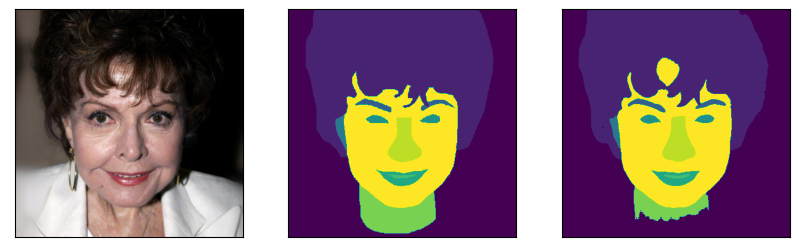

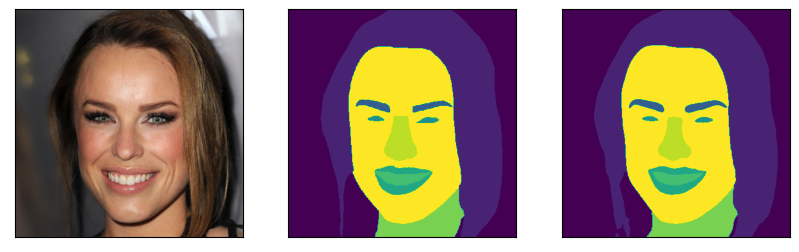

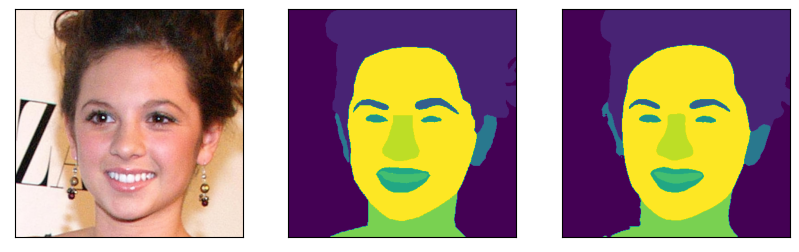

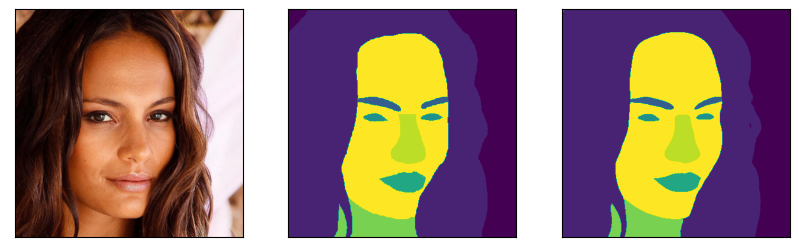

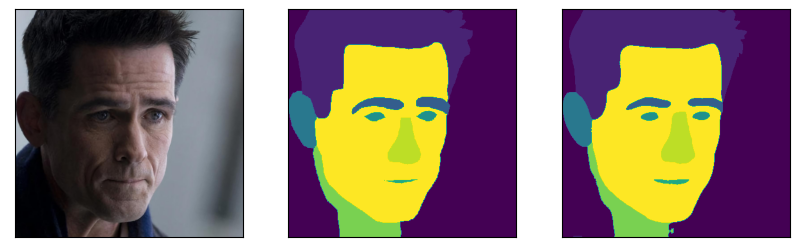

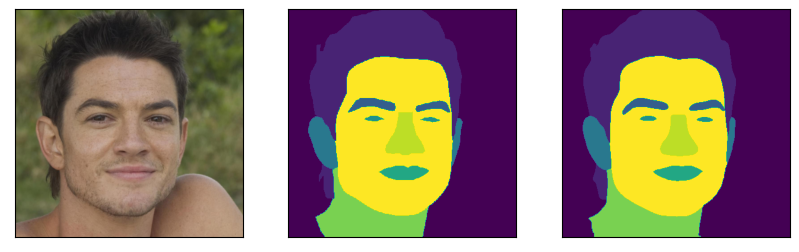

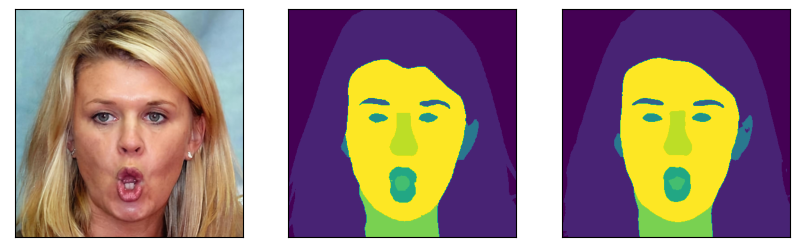

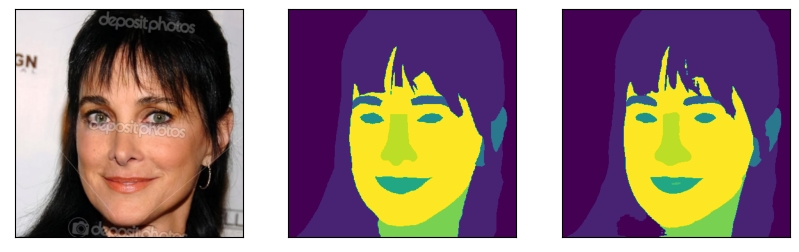

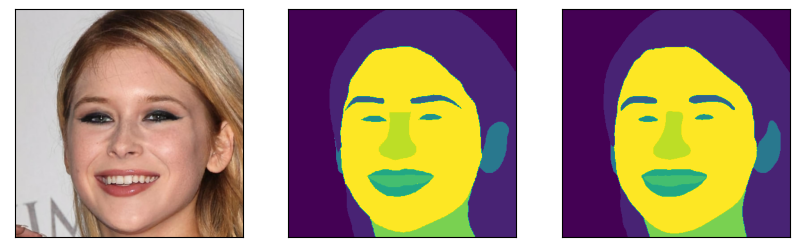

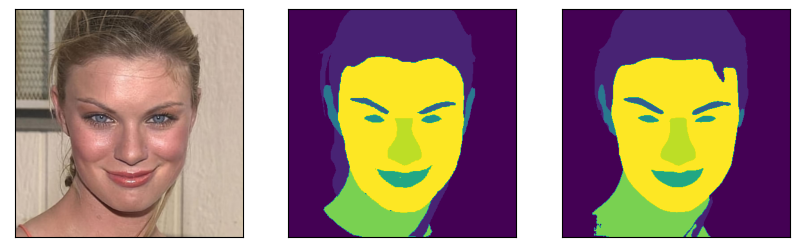

In [14]:
if Validating:
    for epoch in range(10):
        trainer.test(val_loader, epoch)